In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

Inputs:

In [3]:
__inputs__ = create_paths(
    path='data/integration/',
    csv=[
        'rna', 'rna_shared', 'protein', 'protein_shared',
        'patients_with_both', 'genes_in_both'
    ]
)
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'

Outputs:

In [4]:
correlations_path = 'data/integration/' + 'correlations.csv'
differential_correlations_path = 'data/integration/' + 'differential_correlations.csv'

null_path = 'data/integration/correlations/diff_null_distribution/'

Load inputs:

In [5]:
def series_from_csv(path):
    return read_csv(path, index_col=0)['0']

load_inputs(
    globals(), silent=True,
    loaders={'patients_with_both': series_from_csv, 'genes_in_both': series_from_csv},
)

In [6]:
patients_union = list(rna.columns | protein.columns) 
clinical = read_csv(clinical_path, index_col=0).loc[patients_union]
from plots.annotations import generate_patient_annotations
patient_annotations = generate_patient_annotations(clinical)

### 1. Small but noticeable fraction of measurements is missing RNA-seq counts

In [7]:
values = pd.concat([
    rna_shared.reset_index().melt(id_vars='index').assign(omic='RNA'),
    protein_shared.reset_index().melt(id_vars='index').assign(omic='Protein')
])
values['Meningitis'] = values.variable.map(clinical.Meningitis)
values.head(2)

,index,variable,value,omic,Meningitis
0,FGR,001.TMD,6.993258,RNA,Tuberculosis
1,CFH,001.TMD,-1.191528,RNA,Tuberculosis


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


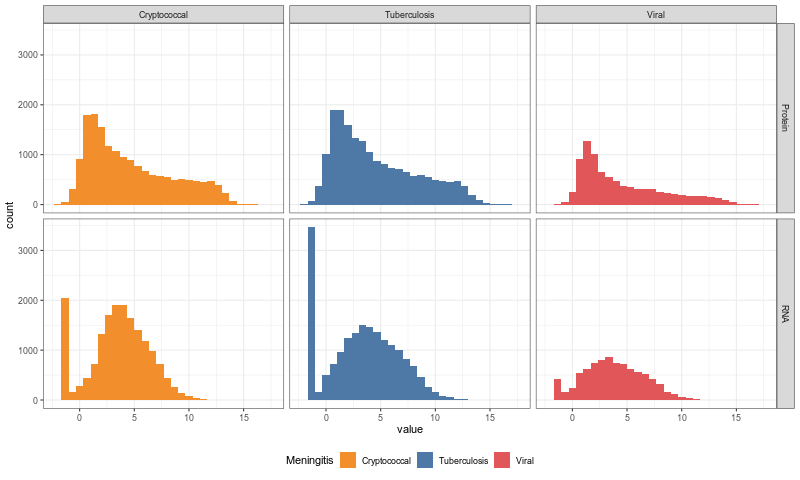

In [8]:
%%R -w 800 -i values
(
    ggplot(values, aes(x=value, fill=Meningitis))
    + facet_grid('omic ~ Meningitis')
    + geom_histogram()
    + scale_fill_manual(values=patient_colors$Meningitis)
    + nice_theme
)

RNA-seq data has clearly many proteins that were not registered for this subset of patients (but not necessarily for all patients - in such case those should have been filtered).
The values appear negative due to the log transformation:

In [9]:
from math import log2

In [10]:
damping_factor = 0.25
log2(0 + damping_factor), log2(1 + damping_factor)

(-2.0, 0.32192809488736235)

And it's about 15% of all RNA values:

In [11]:
values['is_low_count'] = values.value < 0
rna_values = values.query('omic == "RNA"')
len(rna_values.query('is_low_count')) / len(rna_values)

0.15297939068100358

In [12]:
def summarize_low_counts(values):
    return (
        values.groupby(['Meningitis', 'index']).is_low_count.mean().sort_values(ascending=False)
        .to_frame('ratio').reset_index()
    )

In [13]:
rna_low_ratio = summarize_low_counts(rna_values)

There are a few proteins with no (VIP in viral) or almost no counts across all patients in subgroups:

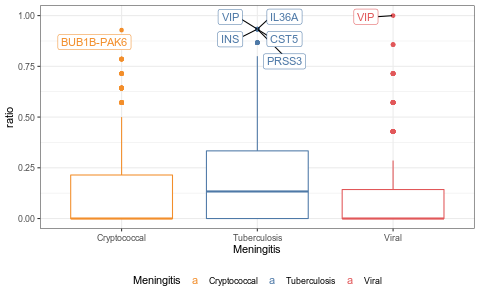

In [14]:
%%R -i rna_low_ratio -h 300
top = rna_low_ratio[rna_low_ratio$ratio >= 0.9, ]
(
    ggplot(rna_low_ratio, aes(x=Meningitis, y=ratio, color=Meningitis))
    + geom_boxplot() + color_meningitis + nice_theme
    + ggrepel::geom_label_repel(
        aes(label=index), data=top,
        nudge_x=c(-0.2, 0.2), direction='y', max.max.overlaps=Inf
    )
)

- VIP - signalling: IL-6, GPCR, Gα.
- IL36α - interleukin 36, inflammatory response, NF-kappa-B and MAPK signaling pathways; thought to be an important factor in counteracting microbial and viral immune evasion [(Jensen LE, 2017)](https://www.ncbi.nlm.nih.gov/pubmed/28811383)
- INS - insulin
- PRSS3 (Trypsin-3) - immune system, neutrophil degranulation, antimicrobial peptides

With even more genes having transcripts completely undetected in the "definite" subgroup of tuberculosis:

In [15]:
tmd_rna_low_ratio = summarize_low_counts(rna_values[rna_values.variable.str.endswith('TMD')])
rna_absent_in_tmd = tmd_rna_low_ratio[tmd_rna_low_ratio.ratio == 1].sort_values('index')
rna_absent_in_tmd

,Meningitis,index,ratio
0,Tuberculosis,C8A,1.0
5,Tuberculosis,DKKL1,1.0
1,Tuberculosis,FGB,1.0
4,Tuberculosis,IGFBP6,1.0
3,Tuberculosis,IL20,1.0
2,Tuberculosis,PRSS3,1.0


- C8A - bacteria killer
- PRSS3 (Trypsin-3) - [as above] immune system, neutrophil degranulation, antimicrobial peptides
- FGB - blood clotting, signaling cascades, platelets, a lot of signaling + VEGFA-VEGFR2
- IL20 - an interleukin 
- DKKL1 - negative regulator of Wnt signaling (dickkopf-like protein)
- IGFBP6 - potential biomarker for TB in HIV+ see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/
- HIST1H3D  - "HIV-1 Tat peptides bind core histones H2A, H2B, H3 and H4, and Tat protein recruits histone acetyltransferases to the HIV-1 LTR promoter leading to acetylation of histones H3 and H4, derepressing chromatin structure and increasing NFkappaB responsiveness"

TODO: why is HIST1H3D no longer captured?

In [16]:
rna_values[rna_values.index == 'HIST1H3D']

,index,variable,value,omic,Meningitis,is_low_count


On IGFBP6:
  > "The remaining two proteins in the HIV+ panel, IGFBP6 and TAGLN2 have unknown roles in infectious diseases. Of note, ligands of IGFBP6 are reduced in sera and pleural fluids of subjects with tuberculous and non-tuberculous pleuritis (Le Bouc et al., 1997)."
 >
 > ![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/bin/gr3.jpg)
 >
 > Fig 3: Differential expression in sera, fold change. ORD = Other respiratory diseases, NI = not infected, LI = latent TB infection, TB = TB infection

From the fig 3 (above) I gather that this is is low against controls (especially in HIV+), and slightly higher against other respiratory diseases (but still not very high).

**TODO** Come to think of it: is the default mean expression filter of DESeq2 wise enough to NOT reject such (completely undetected in one group) cases? Maybe not: fold change in any method would be NaN or zero (but for the damping factor influence, thus more likely +/-∞)! Usually such cases are rare, though such proteins would be perfect biomarkers!

In [17]:
healthy_controls = protein.columns[protein.columns.str.endswith('HC')]
protein_hc = protein.loc[genes_in_both][healthy_controls].reset_index().melt(id_vars='index').assign(omic='Protein', is_low_count=F)

In [18]:
# actually, I could add the patients which are outside of the shared subset here
values_with_hc = pd.concat([values, protein_hc])
values_with_hc['Meningitis'] = values_with_hc.variable.map(clinical.Meningitis)

absent_tmd = values_with_hc.set_index('index').loc[rna_absent_in_tmd['index']].reset_index()

notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went o

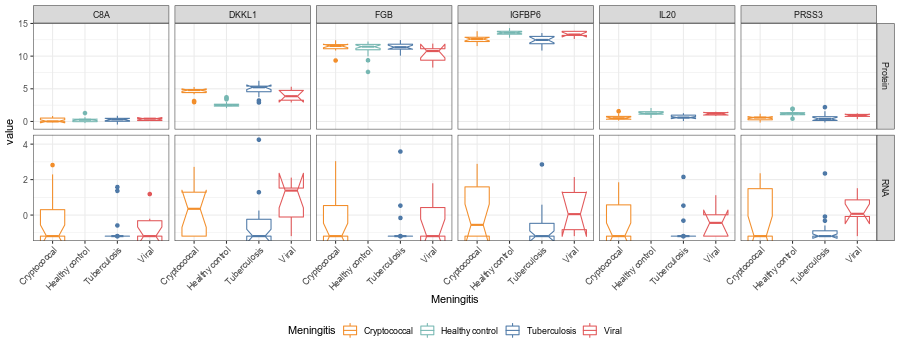

In [19]:
%%R -i absent_tmd -w 900 -h 350
(
    ggplot(absent_tmd, aes(x=Meningitis, y=value, color=Meningitis))
    + geom_boxplot(notch=T) + facet_grid('omic ~ index', scale='free_y')
    + nice_theme + color_meningitis
    + theme(axis.text.x=element_text(angle=45, hjust=1))
)

None of them seem to be differential (for our groups of interest) but there must be a story to be told on IGFBP6 (why is it high in SOMAScan?).

### 2. The RNA and protein profiles are correlated, but not highly

Overall the "naive" correlation (Spearman) between the patient RNA and protein profiles are low:

In [20]:
from scipy.stats import spearmanr

In [21]:
profile_correlations = DataFrame([
    {
        'patient': patient,
        'correlation': spearmanr(protein_shared[patient], rna_shared[patient]).correlation,
        'Meningitis': clinical.loc[patient].Meningitis
    }
    for patient in patients_with_both
]).set_index('patient')

In [22]:
profile_correlations.correlation.mean()

0.11386486572998503

In [23]:
assert profile_correlations.correlation.mean() == profile_correlations.correlation.abs().mean()

And always positvie:

In [24]:
assert (profile_correlations.correlation > 0).all()

notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.


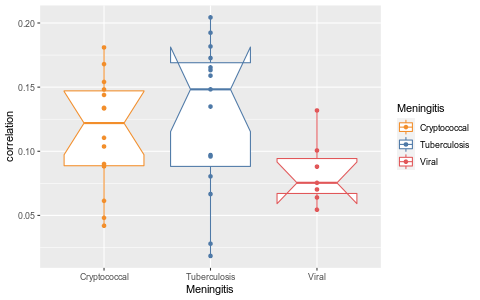

In [25]:
%%R -i profile_correlations -h 300
(
    ggplot(profile_correlations, aes(x=Meningitis, y=correlation, color=Meningitis))
    + geom_boxplot(notch=T) + geom_point()
    + color_meningitis
)

**The correlations for viral meningitis are lower than those for Crypto and TB.**

Note: the distinction betwen (2, above) and (3, below) is similar to "ecological"/"aggregate" vs "individuals" correlations problem. Above I averaged correlations for each gene, while below I consider them independently.

### 3. Correlations for gene-protein pairs are slightly higher
(with RNASeq-SOMAScan pairs having low RNASeq skipped)

If we were to look at the RNA/protein correlations across the samples, we see the absolute mean correlation to be even higher:

In [26]:
from math import sqrt

In [27]:
def geometric_mean(a, b, nullify_if_below_zero=False):
    square_root = (
        (lambda x: sqrt(x) if x > 0 else 0)
        if nullify_if_below_zero else
        sqrt
    )
    product = a * b
    if isinstance(product, Series):
        return product.apply(square_root)
    return square_root(product)

In [28]:
def calc_correlations(rna, protein, method=spearmanr, filter_low_rna_seq=True):
    cor_list = []
    
    for gene in genes_in_both:
        
        r = rna.loc[gene]
        p = protein.loc[gene]
        
        if filter_low_rna_seq:
            # filter out samples (patients) with too few RNA-seq reads for this protein/gene (see above)
            patients_with_enough_rna = r[r > 0].index
            p = p[patients_with_enough_rna]
            r = r[patients_with_enough_rna]
        
        cor = method(r, p)
        
        cor_list.append({
            'gene': gene,
            'rna_abundance': mean(r),
            'protein_abundance': mean(p),
            'abundance_mean': (mean(r) + mean(p)) / 2,
            'abundance_geometric_mean': geometric_mean(mean(r), mean(p), nullify_if_below_zero=True),
            'correlation': cor[0],
            'pvalue': cor[1],
            'n': len(patients_with_enough_rna)
        })
    return DataFrame(cor_list).set_index('gene')

In [29]:
correlations = calc_correlations(rna_shared, protein_shared)
correlations.correlation.abs().mean()

0.17192622435001081

For example the most negatively correlated pairs are:

In [30]:
correlations.sort_values('correlation').head()

,rna_abundance,protein_abundance,abundance_mean,abundance_geometric_mean,correlation,pvalue,n
gene,,,,,,,
IL17A,1.504497,1.283783,1.394140,1.389765,-0.791176,0.000262,16
PRSS3,1.299141,0.685635,0.992388,0.943788,-0.727273,0.011205,11
IL36A,1.543806,3.766252,2.655029,2.411299,-0.650000,0.058073,9
CA1,1.792782,4.053707,2.923245,2.695814,-0.633399,0.001177,23
PTN,1.492978,12.421136,6.957057,4.306331,-0.553571,0.032287,15


$$\text{geometric_mean_abundance} = \sqrt{\text{protein_abundance} \times \text{rna_abundance}}$$

Looking for biomarkers we are mostly interested in effects:
 - supported consistently by larger number of observations
 - for more abundant proteins and transcripts

Use of P-value can address the first issue and filtering will resolve the second - I will adjust FDR filtering low abundance pairs with genefilter package:

In [31]:
%%R
import::here(filter_by_mean_expression, .from='helpers/independent_hypothesis.R')

add_filtered_fdr = function(correlations, expression_col, alpha=0.1) {
    correlations$FDR = filter_by_mean_expression(
        correlations, alpha, expression_col=expression_col, pvalue_col='pvalue', show_plot=F,
        use_deseq2_method=F
    )
    f = sum(sapply(correlations$FDR, is.na))
    p = sum(sapply(correlations$pvalue, is.na))
    print(paste('Filtered:', f - p))
    correlations
}

In [32]:
from helpers.r import r_function

In [33]:
add_filtered_fdr = partial(r_function, 'add_filtered_fdr')

In [34]:
correlations = add_filtered_fdr(correlations, 'abundance_geometric_mean', 0.1)
correlations.sort_values('FDR').head(2)

[1] "Filtered: 967"


,rna_abundance,protein_abundance,abundance_mean,abundance_geometric_mean,correlation,pvalue,n,FDR
COTL1,8.249759,7.295996,7.772878,7.758235,-0.485457,0.002689,36,0.099177
CTSH,6.306867,6.305833,6.306350,6.306350,-0.476963,0.003270,36,0.099177


### 4. Most significant, highly abundant, highly correlated transcript-protein pairs

Positive correlation can tells us about the type of the cell (if there are cell type specific proteins expressed and measured).

Negative correlation can highlight proteins which are expressed but then exported or used up in another way (binding to complexes - own or foreign, signaling).

These correlations characterize CSF cells in meningitis, but we cannot claim any relation to the healthy individuals yet.

In [35]:
def best_hits(correlations, n=5, sort='FDR'):
    dfs = []
    for direction in ['positively', 'negatively']:
        neg = direction == 'negatively'
        c = correlations[correlations.correlation * (-1 if neg else +1) > 0].sort_values(sort)
        for k in c.head(n).index:
            dfs.append(
                DataFrame(dict(
                    RNA=rna_shared.loc[k], Protein=protein_shared.loc[k]
                )).assign(
                    direction=direction, gene=k, FDR=c.loc[k].FDR, p=c.loc[k].pvalue,
                ).rename_axis('patient').reset_index()
            )
    df = pd.concat(dfs)
    df['Meningitis'] = df.patient.map(clinical['Meningitis'])
    df.gene = pd.Categorical(df.gene, categories=correlations[sort].abs().sort_values().index, ordered=T)
    return df

In [36]:
df = best_hits(correlations, n=5, sort='FDR')

`geom_smooth()` using formula 'y ~ x'


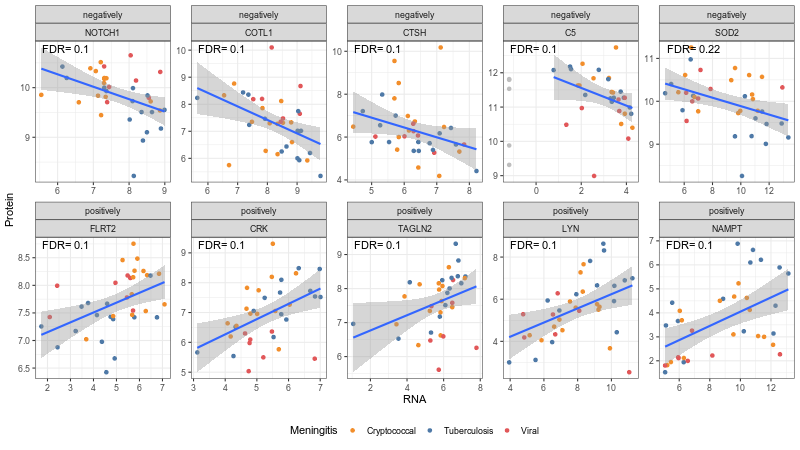

In [37]:
%%R -i df -w 800 -h 450
low_rna = df[df$RNA < 0,]
high_rna = df[df$RNA >= 0,]
(
    ggplot(high_rna, aes(x=RNA, y=Protein))
    + facet_wrap('direction ~ gene', 2, scale='free')
    + geom_point(aes(color=Meningitis))
    + geom_point(color='grey', data=low_rna)
    + geom_smooth(method = "lm")
    + geom_text(aes(label=paste('FDR=', round(FDR, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15)
    + color_meningitis + nice_theme
)

Here are RefSeq based summaries for the above hits:

The most negatively correlated 5:
- HIST1H3D - a histone; may be important in cell proliferation, apoptosis and cell cycle progression (in cancer); RNASeq reads absent in all but two TB patients(!)
- LAMC1 - extracellular matrix glycoprotein; "Upregulated by HIV infection or Tat protein"
- CA1 - zinc metalloenzyme; involved in formation of cerebrospinal fluid (among others); cytosolic, high in erythrocytes; potential oncogene (abnormal cell calcification, apoptosis and migration in breast cancer)
- IFNGR2 - receptor for Interferon gamma (variants are a cause of susceptibility to **mycobacterial** infections!)
- COTL1 - involved in many autoimmune disorders and cancers; related to IL-24/TGF-beta signaling

The most positively correlated 5:
- FCN1 - predominantly expressed in peripheral blood leukocytes; immune system; Neutrophil degranulation; Ebolva virus infection
- FLRT2 - neural development; cell adhesion molecule; possible role in cellular growth and proliferation; tumour suppressor in breast cancer
- COLEC11 - secreted protein; **"important roles in the innate immune system by binding to carbohydrate antigens on microorganisms, facilitating their recognition and removal"**
- TAGLN2 - "thought to be a tumor suppressor", HIV-1 likes this protein: gp120 upregulates it and it needs it to replicate; Platelet activation, signaling and aggregation
- NAMPT - NAPRTase family; involved in many important biological processes, including metabolism, stress response and aging

Further down the list:

In [38]:
export_columns = ['correlation', 'n', 'protein_abundance', 'rna_abundance', 'pvalue', 'FDR']
significant_table = correlations.sort_values('FDR')[export_columns]
significant_table.to_csv(correlations_path)

In [39]:
show_table(significant_table.head(20))

,correlation,n,protein_abundance,rna_abundance,pvalue,FDR
COTL1,-0.485457,36,7.295996,8.249759,0.002689,0.099177
CTSH,-0.476963,36,6.305833,6.306867,0.003270,0.099177
NAMPT,0.515573,36,3.668087,8.714387,0.001290,0.099177
C5,-0.520968,31,11.297655,3.007013,0.002656,0.099177
NOTCH1,-0.505019,36,9.842531,7.701370,0.001682,0.099177
TAGLN2,0.521236,36,7.595739,5.696156,0.001115,0.099177
CRK,0.478507,36,6.951883,5.339063,0.003157,0.099177
FLRT2,0.545689,36,7.678922,4.961874,0.000577,0.099177
LYN,0.482368,36,5.535760,7.914809,0.002889,0.099177
SOD2,-0.435779,36,9.993065,8.919466,0.007892,0.215457


#### 4.1 The most significant low-expressed pairs

In [40]:
low_expressed = correlations[correlations.FDR.isnull()]
df = best_hits(low_expressed, n=5, sort='pvalue')

`geom_smooth()` using formula 'y ~ x'


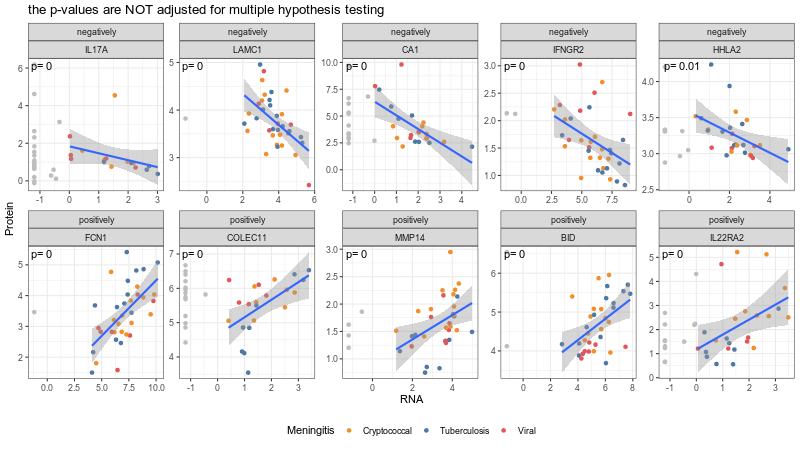

In [41]:
%%R -i df -w 800 -h 450
low_rna = df[df$RNA < 0,]
high_rna = df[df$RNA >= 0,]
(
    ggplot(high_rna, aes(x=RNA, y=Protein))
    + facet_wrap('direction ~ gene', 2, scale='free')
    + geom_point(aes(color=Meningitis))
    + geom_point(color='grey', data=low_rna)
    + geom_smooth(method = "lm")
    + geom_text(aes(label=paste('p=', round(p, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15)
    + color_meningitis + nice_theme
    + ggtitle('the p-values are NOT adjusted for multiple hypothesis testing')
)

- Either interleukins are enriched in SOMAScan design or those have some special role here; correlations:
  - negative: IL17A, IL11
  - positive: IL22RA2 (receptor) [but IL22 is not expressed in 80% of TB patients, 60% of Crypto and 50% of Viral...]
- Interferon Β (IFNB1) has positive correlation while Receptor for Interferon γ (IFNGR2) has negative one
- PRSS3 is not expressed in 93% of the TB patients! (or at least not detected)

In [42]:
rna_low_ratio[rna_low_ratio['index'] == 'IL22']

,Meningitis,index,ratio
41,Tuberculosis,IL22,0.800000
235,Cryptococcal,IL22,0.571429
444,Viral,IL22,0.428571


### 5. Negative correlations are less frequent than positive correlations

(thus should not invalidate the RNASeq analyses, but are an important factor to consider)

In [43]:
# only use pvalue < 0.5, otherwise we are lookking at meaningless noise
# (and I assume that p-values are callibrated up to this level)
not_noise = correlations.query('pvalue < 0.5')

positive_correlations = not_noise.query('correlation > 0')
negative_correlations = not_noise.query('correlation < 0')

In [44]:
len(positive_correlations)

422

In [45]:
len(negative_correlations)

247

#### 5.1 Trends in the pathways space of the positively and negatively correlated pairs differ

Using camera with 1 - p-value gives us an over-representation analysis proxy, but this is actually even worse as it does not use background. Thus, please do not take the FDR/PValue seriously, these are not valid.

In [46]:
from gsea_api.expression_set import ExpressionSet
from gsea_api.molecular_signatures_db import GeneMatrixTransposed
from helpers.gse import collection_to_R

reactome_new_symbol = GeneMatrixTransposed.from_gmt('data/ReactomePathways.gmt', name='reactome_new_symbol')
collection_to_R(reactome_new_symbol, trim_to=set(genes_in_both))

%R camera = function(x) {limma::cameraPR(x, reactome_new_symbol)}
camera = partial(r_function, 'camera')

/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:65: UserWarning: Provided gene sets are not redundant; there are 117 gene sets having more than one name assigned; use `find_redundant()` to investigate further.
  warn(message)
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:65: UserWarning: Provided gene sets are not redundant; there are 201 gene sets having more than one name assigned; use `find_redundant()` to investigate further.
  warn(message)
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:75: UserWarning: There are 699 empty gene sets: use `empty_gene_sets` property to investigate further.
  warn(f'There are {len(empty_gene_sets)} empty gene sets: {empty_message}')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signa

In [47]:
# well, actually why would there be any trend for positive correlations?
# this is just how the "normal" cell in the simplest version of the central dogma works,
# so even with proper ORA I would not expect any serious significant signal here
camera(1 - positive_correlations.pvalue).head()

,NGenes,Direction,PValue,FDR
Intrinsic Pathway of Fibrin Clot Formation,6.0,Down,0.023442,0.991311
Signaling by SCF-KIT,12.0,Up,0.024007,0.991311
Downstream signal transduction,10.0,Up,0.028280,0.991311
Growth hormone receptor signaling,8.0,Up,0.034457,0.991311
Non-integrin membrane-ECM interactions,9.0,Up,0.034510,0.991311


In [48]:
# kind of as expected ("gut feeling"?), but needs proper ORA framework
camera(1 - negative_correlations.pvalue).head()

,NGenes,Direction,PValue,FDR
Interleukin-10 signaling,6.0,Up,0.002846,0.997644
Metabolism,44.0,Down,0.011789,0.997644
Signaling by Interleukins,38.0,Up,0.013312,0.997644
Metabolism of carbohydrates,15.0,Down,0.017125,0.997644
Leishmania infection,4.0,Up,0.023189,0.997644


I verified using gProfiler and got no significant hits.

In [49]:
# neg = negative_correlations.index

In [50]:
#%%R -i neg -i genes_in_both -o go_result
#go_result <- gprofiler2::gost(neg, custom_bg=genes_in_both, ordered_query=T, significant=T)
#head(go_result)

### 6. A look at the consistently (highly expressed gene-highly abundant protein) pairs (across all groups)

In [51]:
correlations.sort_values('abundance_geometric_mean', ascending=False).head(10)

,rna_abundance,protein_abundance,abundance_mean,abundance_geometric_mean,correlation,pvalue,n,FDR
B2M,10.834460,11.837194,11.335827,11.324734,-0.298584,0.076914,36,0.411715
IGHG1,10.469489,10.772982,10.621236,10.620152,0.050450,0.770129,36,0.930289
YWHAZ,8.822053,12.689994,10.756023,10.580728,-0.154955,0.366852,36,0.855988
SELL,8.500499,12.675817,10.588158,10.380307,-0.101673,0.555163,36,0.881608
IGHA1,9.176793,11.589848,10.383321,10.312984,0.015701,0.927581,36,0.987845
ALDOA,8.134703,12.620901,10.377802,10.132486,-0.007207,0.966724,36,0.995405
HNRNPA2B1,9.735091,10.323523,10.029307,10.024991,0.129215,0.452601,36,0.870142
CTSD,7.715334,12.694833,10.205083,9.896710,-0.204633,0.231234,36,0.725595
TNFRSF1B,7.766196,12.433110,10.099653,9.826392,-0.269755,0.111594,36,0.489774
YWHAB,7.951955,12.033815,9.992885,9.782247,0.083655,0.627628,36,0.881608


Top 5:
- B2M - β2-microglubulin: related to MHC, HIV Infection (Host Interactions), IL-12, interferon, TCR singaling
- IGHG1 - immunoglobulin heavy constant gamma; immune system, IL4, IL13
- YWHAZ - mediates signal transduction, lots of pathways, interacts with insulin receptor substrate 1
- SELL - strong association with HIV-1; proposed as biomarker for tuberculosis in HIV negative patients [(Achkar et al, 2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/) (well, maybe this is like checking if they may happen to have latent HIV...)
- IGHA1 - immunoglobulin heavy constant alpha 1; IL17; antibacterial humoral response

Note: I am finding many of the proteins that I check to be associated with to Systemic Lupus. 

### 7. Differential correlations analysis - intruduction

Are there any pairs positively correlated in one meningitis but negatively in the other?

In [52]:
tb_patients = patients_with_both[patients_with_both.str.contains('TMD|TMR|TMS')]
cm_patients = patients_with_both[patients_with_both.str.contains('CM')]

correlations_tb = calc_correlations(rna_shared[tb_patients], protein_shared[tb_patients])
correlations_cm = calc_correlations(rna_shared[cm_patients], protein_shared[cm_patients])

#### 7.1 Absolute correlations for TB are (on average) higher, and the correlations are more positive for TB

In [53]:
joint_correlations = pd.concat([
    correlations_cm.assign(Meningitis='Cryptococcal'),
    correlations_tb.assign(Meningitis='Tuberculosis')
])
joint_correlations = joint_correlations.assign(abs_correlation=joint_correlations.correlation.abs())

In [55]:
%%R
library(ggrepel)
set.seed(0)

ggbetweenstats = function(data, x, y) {
    (
        ggplot(data, aes_string(x=x, y=y))
        + ggbeeswarm::geom_quasirandom(aes_string(color=x))
        + geom_boxplot(width=0.2, notch=TRUE, alpha=0.5, outlier.shape=NA)
        + stat_summary(fun.data='mean_cl_boot', colour='red', size=1)
        + stat_summary(
            aes(label=round(..y.., 2)), fun.y='mean', geom='label_repel',
            direction='x', min.segment.length=0, box.padding=2
        )
        + nice_theme
    )
}

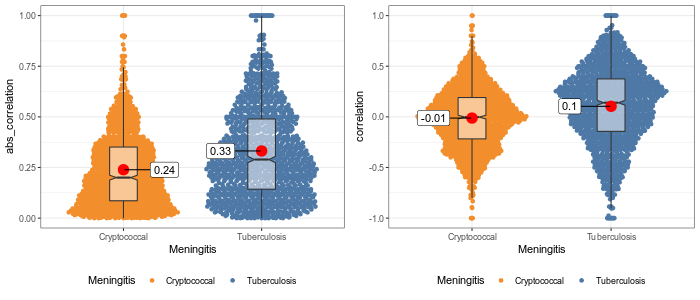

In [56]:
%%R -i joint_correlations -w 700 -h 300
cowplot::plot_grid(
    ggbetweenstats(data=joint_correlations, x='Meningitis', y='abs_correlation') + color_meningitis,
    ggbetweenstats(data=joint_correlations, x='Meningitis', y='correlation') + color_meningitis
)

And the effect persists after filtering out the non-significant hits:

In [57]:
joint_correlations_without_noise = joint_correlations.query('pvalue < 0.1')
joint_correlations_without_noise.groupby('Meningitis').mean()[['correlation', 'abs_correlation']]

,correlation,abs_correlation
Meningitis,,
Cryptococcal,-0.054387,0.615221
Tuberculosis,0.216181,0.641996


- Maybe more proteins measured in the TB are produced "on-site" (in the cells present in the CSF) rather imported with migrating cells which matured outside of the CSF?
- Maybe there are just more proteins measured in the TB, thus it's easier to get a high correlation?

In [58]:
clinical.groupby('Meningitis').Protein.mean().to_frame().T

Meningitis,Bacterial,Cryptococcal,Healthy control,Tuberculosis,Viral
Protein,2.76,1.298889,0.4088,2.894688,0.6925


#### 7.2 In the subsets there are some perfect correlations, but with support from very few patients

Filtering/weighting is thus needed for the subsets as such hits are not very interesting:

In [59]:
correlations_tb.sort_values('pvalue').head(2)

,rna_abundance,protein_abundance,abundance_mean,abundance_geometric_mean,correlation,pvalue,n
gene,,,,,,,
CST4,0.850911,0.079935,0.465423,0.260801,1.0,0.0,3
DKKL1,1.931231,4.794821,3.363026,3.043010,-1.0,0.0,3


In [60]:
correlations_cm.sort_values('pvalue').head(2)

,rna_abundance,protein_abundance,abundance_mean,abundance_geometric_mean,correlation,pvalue,n
gene,,,,,,,
IL17F,2.099416,-0.005236,1.047090,0.000000,-1.0,0.0,3
TPSG1,0.944054,0.513789,0.728922,0.696452,1.0,0.0,3


I will be weighting the hits by minimal $n$ across the compared groups.

In [61]:
def absolute_correlation_difference(cm, tb):
    return (cm.correlation - tb.correlation).abs()

In [62]:
cm_tm = DataFrame(dict(
    cm_correlation=correlations_cm.correlation,
    tb_correlation=correlations_tb.correlation,
    diff=absolute_correlation_difference(correlations_cm, correlations_tb),
    abundance_mean=correlations_cm.abundance_mean + correlations_tb.abundance_mean,
    abundance_geometric_mean=geometric_mean(
        correlations_cm.abundance_geometric_mean,
        correlations_tb.abundance_geometric_mean,
    ),
    cm_n=correlations_cm.n,
    tb_n=correlations_tb.n,
    n_geometric_mean=geometric_mean(correlations_cm.n, correlations_tb.n)
)).dropna().sort_values('diff', ascending=False)

cm_tm.head(2)

,cm_correlation,tb_correlation,diff,abundance_mean,abundance_geometric_mean,cm_n,tb_n,n_geometric_mean
gene,,,,,,,,
CA9,0.9,-1.0,1.9,3.454228,1.703308,5,2,3.162278
FGB,-0.8,1.0,1.8,13.096662,4.347449,5,2,3.162278


Obviously perfect correlation for $n=2$ is not interesting...

### 8. Methods for significance estimation for correlations analysis

#### 8.1 Significance estimation with permutation tests

For the permutation test we can:
- a) reshuffle labels of patients within phenotypes (here: within meningitis subgroups), or
- b) keep the paired observations together but reshuffle phenotypes (here: meningitis type), or
- c) reshuffle entire phenotypes (all labels without any prior separation except for keeping omics separately)

The latter is used in GSEA, but GSEA operates on aggregate rather level than using paired hypothesis.

Rephrasing in terms of tested hypotheses, the two scenarios assess null for:
- a) "no structure" hypothesis - A: the difference in relations (as strong as observed) of RNA and Protein levels for given groups is stronger than expected from random pairing of the RNA-Protein data.
- b) "no difference between groups" - A: the difference in relations as strong as observed would not be seen from random assignment of patients to TB/crypto groups
- c) "no difference between groups and/or no structure" - A: the relations as strong as observed would not come out from completely random data

By rejecting the (a) null we can claim that the effects in the experimental measurement procedure which could be attributed to random factors and differ between RNA and Protein measurements of a single patient (e.g. the time delay in sequencing which results from the data being processed in two different centers) do not explain the observed relation.

**Ideally we would want to reject all three hypotheses, but not rejecting either (a) or (b) gives us a meaningful interpretation as well. For the sake of the study, (b) is the most important one (but we also want to reject c!).**

For sake of completeness, further to the mentioned permutation scenarios we could reshuffle RNA-protein assignment, but it is not obvious to me what would be the interpretation of such a test without making some additional assumptions.

Methods details for write-up:
 - sample permutation because genes are not independent (https://www.ncbi.nlm.nih.gov/pubmed/21044043)
 - re-sampling with repetitions (also 21044043)
 - permutation test (as this is better for testing that bootstrap which allows for replacements)
 - 10^5 permutations

#### 8.2 Filtering by p-value from Spearmanr?

One way to reduce the number of tests is to only consider significant correlations in the first place. However, there is dependence between such filtering and the filtering that we would like to do later on, thus in order to prevent having deflated FDR q-values I will not do that. On the other hand this could also inflate the p-values in permutation testing.

Importantly (according to the documentation) the p-values from `scipy.stats.spearmanr` are not reliable for datasets as small as our gene-wise RNA-protein correlations (< 40 observations each):

> The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
[[source]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)

#### 8.3 Similar methods in other publications 

Literature search for methods that measure the change in correlation:
- ["Integrative analysis reveals disrupted pathways regulated by microRNAs in cancer"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5814839/#M1) makes use of:
 - absolute difference in the Spearman correlations
 - permutation tests (Equation 1, Table 1, Figure 1; Note: the figure is a very interesting inspiration for a cartoon!)
- ["Modelling high content proteomics data in a signalling context" thesis](https://www.ebi.ac.uk/sites/ebi.ac.uk/files/shared/documents/phdtheses/Terfve.pdf), pages 67-73:
 - uses absolute difference in Pearson correlations
 - names the figure 3.10 "Comparative analysis of correlation patterns between [...]" - sounds slightly better than "differential correlations analysis" to me.
 - interestingly, the author looks at correlations between proteins sharing a functional link (which could be a next step if this project was a PhD project).
 - significance testing on the level of individual correlations only
- ["Exceptional Model Mining"](https://link.springer.com/content/pdf/10.1007/978-3-540-87481-2_1.pdf) explains a mathematical framework for correlation models in 3.1. They:
 - note the problem of the absolute correlations difference not accounting for the size of the group.
 - propose to use entropy of the split, which is adequate to their modeling objective (search for two subgroups) but not to ours.
 - propose a significance measure for correlation difference: assuming bivariate normal distribution of correlation coefficients they use Fisher z-transform to make the data approximately normal and follow with standard p-value calculation procedure.
 
This search was not exhaustive. Search terms: "absolute correlation difference", "absolute correlations difference", "absolute difference of correlations".

#### 8.4 Simple p-values calculation

Methods details for write-up:
 - biased p-value estimator as in https://www.ncbi.nlm.nih.gov/pubmed/21044043
 - GPD is nice but was not needed

In [63]:
from helpers.p_values import ecdf_p_value, gpd_p_value

In [64]:
from helpers.correlations.comparative import ComparativeCorrelations

cm_tm_comparative = ComparativeCorrelations(
    rna=rna_shared,
    protein=protein_shared,
    tb_patients=tb_patients,
    cm_patients=cm_patients,
    method=spearmanr,
    genes_in_both=genes_in_both
)

In [65]:
p_adjust = partial(r_function, 'p.adjust')

def add_p_values(target, null, suffix='', fdr_method='BH', add_diagnostics=False):
    p_name = f'p_value{suffix}'
    q_name = f'FDR{suffix}'
    target = copy(target)
    if len(null.columns) < 250:
        print('Using ECDF')
        target[p_name] = ecdf_p_value(target['diff'], null)
    else:
        print('Using GPD/ECDF')
        p_values = gpd_p_value(target['diff'], null)
        target[p_name] = p_values.p_value
        if add_diagnostics:
            target[f'gpd_gof{suffix}'] = p_values.gof
            target[f'is_gpd{suffix}'] = p_values.is_gpd
            target[f'ecdf_p{suffix}'] = p_values.ecdf_p
    target[q_name] = p_adjust(target[p_name], fdr_method)
    return target.sort_values([q_name, p_name])

In [66]:
absolute_diff_b = cm_tm_comparative.compute_null_distribution(
    metric=absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=100
)
add_p_values(cm_tm, absolute_diff_b, suffix='.pairs').head()

100%|██████████| 100/100 [00:42<00:00,  3.40it/s]

Using ECDF


,cm_correlation,tb_correlation,diff,abundance_mean,abundance_geometric_mean,cm_n,tb_n,n_geometric_mean,p_value.pairs,FDR.pairs
gene,,,,,,,,,,
MATN3,0.550000,-0.761905,1.311905,3.223688,1.583257,9,8,8.485281,0.009901,0.626555
KPNB1,-0.463736,0.675000,1.138736,14.703428,7.321717,14,15,14.491377,0.009901,0.626555
STAT1,-0.353846,0.757143,1.110989,14.197238,6.450739,14,15,14.491377,0.009901,0.626555
LYVE1,-0.362637,0.713287,1.075924,12.627764,5.438554,13,12,12.489996,0.009901,0.626555
STAT3,-0.182418,0.803571,0.985989,15.075187,7.502144,14,15,14.491377,0.009901,0.626555


#### 8.5 Experiment: understanding weighting in context on permutation tests 

In order to boost the results for genes with support in measurements from more patients (i.e. having detectable RNASeq levels across all or almost all patients), modifications to the objective function were considered.

I aimed to choose a weight function $w$ which satisfies following objectives:
  - I) down-weight genes with few patients in one of the groups
  - II) up weight genes with more patients

To address the aims I and II, two approaches were considered: min(cm.n, tb.n) and $cm.n * tb.n$. The latter was chosen as the former does not satisfy II.

Because multiplication of two positives, comparable numbers transforms the average number of patients from $n$ to $\approx n^2$, to prevent the over-weighting of the genes expressed in large number of patients, a square root transform (correlations) was introduced which is more natural in this setting than the log-transform (a popular alternative), because the two operations (multiplication and square root) compose into geometric mean.

Why geometric mean $\sqrt{cm.n \cdot tb.n}$ is better than arithmetic mean $\frac{cm.n + tb.n}{2}$?
 - where one side has few expressed genes the former will give us 0, the latter some positive number (and we would prefer 0 as it shows how non-interpretable is the value).
 - consider two cases, both with 30 patients in total:
     - 10, 20: mean = 15, sqrt(10*20) = 14.142135624
     - 15, 15: mean = 15, sqrt(15*15) = 15
 
 As we would prefer to trust the second case, we can see another advantage of the geometric mean. Note: this is in a relation to the split entropy(?).
 
More examples:
- 2, 28: mean = 15, sqrt(2*28) = 7.483314774

In [67]:
def geometric_absolute_correlation_difference(cm, tb):
    return (cm.correlation - tb.correlation).abs() * (cm.n * tb.n).apply(sqrt).apply(sqrt)

In [68]:
geometric_absolute_diff_b = cm_tm_comparative.compute_null_distribution(
    metric=geometric_absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=100
)

100%|██████████| 100/100 [00:42<00:00,  3.26it/s]

In [69]:
add_p_values(cm_tm, geometric_absolute_diff_b, suffix='.pairs').sort_values('p_value.pairs').head()

Using ECDF


,cm_correlation,tb_correlation,diff,abundance_mean,abundance_geometric_mean,cm_n,tb_n,n_geometric_mean,p_value.pairs,FDR.pairs
gene,,,,,,,,,,
MMP12,0.500000,-1.0,1.500000,4.172917,1.778745,7,2,3.741657,0.069307,1.0
MPL,0.900000,-0.5,1.400000,1.304004,0.000000,5,3,3.872983,0.128713,1.0
CA9,0.900000,-1.0,1.900000,3.454228,1.703308,5,2,3.162278,0.158416,1.0
IFNB1,0.380952,-1.0,1.380952,2.454841,0.995558,8,3,4.898979,0.207921,1.0
CST4,-0.500000,1.0,1.500000,1.528874,0.347045,3,3,3.000000,0.267327,1.0


However, weighting by the geometric mean does not work with the permutation test algorithm because:
- genes which are not expressed in most of the patients often get zero. If those are also perfectly correlated, the p-value defined as mean(observed > null) will be also zero (0 > 0 = False) for considerable number of cases.
- for cases other than A, the $n$ changes. As $n$ changes, the $w$ result changes and influences the weighted correlation drastically.
  - this is essentially addition of another distribution being a function of total $n$ for each gene; we see a lot of "noise" originating from the number of measured transcripts, but rather than increasing stability of the $r$ with increasing $n$, it decreases it; this is the correct behavior, but rather than helping us highlight the interesting genes, it highlights how weak unstable is the weighting function.

The normalization to the total $n$ available for the gene will solve stability issues, but make the weight invariant to the number of samples, thus making it's effect similar to that of the entropy weighting (but distinct).

$$w = \frac{\sqrt{cm.n \cdot tb.n}}{cm.n + tb.n}$$

In [70]:
def weighted_absolute_correlation_difference(cm, tb):
    return (cm.correlation - tb.correlation).abs() * (cm.n * tb.n).apply(sqrt) / (cm.n + tb.n)

In [71]:
s_weighted_absolute_diff_b = cm_tm_comparative.compute_null_distribution(
    metric=weighted_absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=100
)

100%|██████████| 100/100 [00:51<00:00,  1.87it/s]

In [72]:
add_p_values(cm_tm, s_weighted_absolute_diff_b, suffix='.pairs').head()

Using ECDF


,cm_correlation,tb_correlation,diff,abundance_mean,abundance_geometric_mean,cm_n,tb_n,n_geometric_mean,p_value.pairs,FDR.pairs
gene,,,,,,,,,,
CA9,0.900000,-1.0,1.900000,3.454228,1.703308,5,2,3.162278,0.009901,0.032756
FGB,-0.800000,1.0,1.800000,13.096662,4.347449,5,2,3.162278,0.009901,0.032756
MMP1,0.800000,-1.0,1.800000,5.015135,2.040273,4,2,2.828427,0.009901,0.032756
LGALS7,-0.700000,1.0,1.700000,3.044426,1.400008,5,2,3.162278,0.009901,0.032756
FUT5,-0.892857,0.8,1.692857,3.915314,1.855040,7,5,5.916080,0.009901,0.032756


In [73]:
from math import log2

def entropy(cm_n, tb_n):
    cm_n = cm_n.n + 0.25
    tb_n = tb_n.n + 0.25
    n = cm_n + tb_n
    return -(- cm_n / (n) + Series(cm_n/n).apply(log2) - tb_n / (n) + Series(tb_n/n).apply(log2))

In [74]:
entropy_diff_b = cm_tm_comparative.compute_null_distribution(
    metric=entropy,
    constraint='omics-and-observation-pairs', n=100
)

100%|██████████| 100/100 [01:01<00:00,  2.19it/s]

In [75]:
add_p_values(cm_tm, entropy_diff_b, suffix='.pairs').head()

Using ECDF


,cm_correlation,tb_correlation,diff,abundance_mean,abundance_geometric_mean,cm_n,tb_n,n_geometric_mean,p_value.pairs,FDR.pairs
gene,,,,,,,,,,
CA9,0.900000,-1.0,1.900000,3.454228,1.703308,5,2,3.162278,1.0,1.0
FGB,-0.800000,1.0,1.800000,13.096662,4.347449,5,2,3.162278,1.0,1.0
MMP1,0.800000,-1.0,1.800000,5.015135,2.040273,4,2,2.828427,1.0,1.0
LGALS7,-0.700000,1.0,1.700000,3.044426,1.400008,5,2,3.162278,1.0,1.0
FUT5,-0.892857,0.8,1.692857,3.915314,1.855040,7,5,5.916080,1.0,1.0


Considering how weighting does not improve the results in respect to the objective of boosting genes with more support in the data, and that adds another layer of complexity into the objective function, I decided not to include weighting in the final permutation testing procedure.

#### 8.6 Assessing the coverage of the permutation tests

The available computional resources allowed me to reach 10^5 permutations. How much of a coverage does it gives us for the (b) hypothesis?

In [76]:
cm_tm.tb_n.max(), cm_tm.cm_n.max()

(15, 14)

If we only consider possible combinations:

In [77]:
from scipy.special import comb
comb(29, 14)

77558760.0

$$\binom{29}{14} = 77.558.760$$

In [78]:
f'{100*10**5/77558760:.3f}'

'0.129'

Thus in the "worst case", our 10^5 permutations will cover less (because of repetitions and order) than 0.13% of the possible combinations (there are 352 cases with detectable RNA levels in all patients).

In [79]:
cm_tm.tb_n.mean(), cm_tm.cm_n.mean()

(11.94003241491086, 12.154781199351701)

In [80]:
f'{100*10**5/comb(12 + 12, 12):.3f}'

'3.698'

For the average case this would be below 3.7%.

### 9. Differential correlations analysis - results

Which show that Several gene-protein pairs exhibit strong opposite correlations in TB and crypto.

#### 9.1 Computation of null distributions for hypotheses (a), (b), and (c)

In [81]:
n_permutations = 1_000
chosen_metric = absolute_correlation_difference

In [82]:
!mkdir -p {null_path}

In [83]:
def final_compute_null(constraint):
    file_name = 'keep_' + constraint.replace('-', '_') + f'-n_{n_permutations}.csv.gz'
    path = null_path + file_name
    
    if not Path(path).exists():
        # this takes about 8 hours for each null with 100_000
        null = cm_tm_comparative.compute_null_distribution(
            metric=chosen_metric, constraint=constraint, n=n_permutations
        )
        null.to_csv(path)
    else:
        # TODO: this takes about five minutes for each file...
        #  Only read first N permutations for reproducibility build?
        null = read_csv(path, index_col=0)
    return null

##### a) constraint: omics and phenotypes

In [84]:
keep_phenotypes = final_compute_null(constraint='omics-and-phenotypes')

##### b) constraint: omics and observation pairs

In [85]:
keep_observation_pairs = final_compute_null(constraint='omics-and-observation-pairs')

##### c) constraint: omics

In [86]:
keep_omics = final_compute_null(constraint='omics')

#### 9.2 Comparison of nulls

These are not the final results - scroll down for FDR corrected p-values.

In [87]:
nulls = {
    'a) omics & phenotypes': keep_phenotypes,
    'b) omics & observation pairs': keep_observation_pairs,
    'c) omics': keep_omics
}
assert (
    all(keep_omics.index == keep_phenotypes.index)
    and
    all(keep_omics.index == keep_observation_pairs.index)
)

Intuitively, the most important meta-statistic is the maximum, which may (but does not have to) correlate with the number of rejections:

In [88]:
gene_maxima = DataFrame({name: null.max(axis=1) for name, null in nulls.items()}).melt()

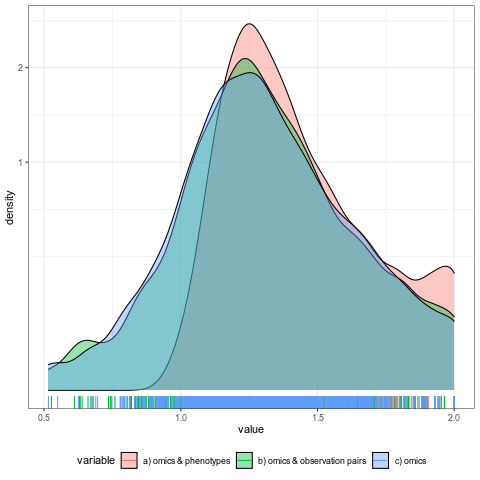

In [89]:
%%R -i gene_maxima
(
    ggplot(gene_maxima, aes(x=value, fill=variable))
    + geom_density(alpha=0.4) + nice_theme + scale_y_sqrt()
    + geom_rug(aes(color=variable))
)

The important take-away is that scoring a "perfect" (2.0) or "high" (1.5) pair of inverse correlations is not so difficult if enough permutations are performed.

Maybe, the frequency of absolute correlation differences peaking at ~1.6 might have been expected (with a few additional assumptions) - if we consider it as maximum of absolute differences of expected values of two half-normal distributions:

In [90]:
from math import pi
expected_half = sqrt(2)/sqrt(pi)
2 * expected_half

1.595769121605731

Sanity check: I expect the means of iterations to have comparable, nice distributions

In [91]:
iteration_means = DataFrame({name: null.mean(axis=0) for name, null in nulls.items()}).melt()

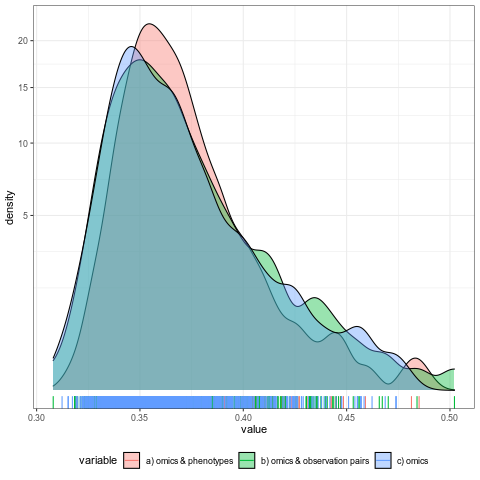

In [92]:
%%R -i iteration_means
(
    ggplot(iteration_means, aes(x=value, fill=variable))
    + geom_density(alpha=0.4) + nice_theme + scale_y_sqrt()
    + geom_rug(aes(color=variable))
)

In [93]:
short_names = {n: n[11:] if '&' in n else n[3:] for n in nulls}
result = cm_tm
for n, v in nulls.items():
    result = add_p_values(result, v, suffix='.' + short_names[n])

Using GPD/ECDF


/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/krassowski/meningitis-integration/helpers/p_values.py:133: UserWarning: A good GPD fit could not be reached, using ECDF estimate instead
  warn(f'A good GPD fit could not be reached, using ECDF estimate instead')


Using GPD/ECDF
Using GPD/ECDF


In [94]:
result.head(2)

,cm_correlation,tb_correlation,diff,abundance_mean,abundance_geometric_mean,...,FDR.phenotypes,p_value.observation pairs,FDR.observation pairs,p_value.omics,FDR.omics
gene,,,,,,,,,,,
KPNB1,-0.463736,0.675000,1.138736,14.703428,7.321717,...,0.60308,0.045223,0.587032,0.000999,0.578335
TNFRSF8,0.468132,-0.643956,1.112088,6.920582,3.438134,...,0.60308,0.025646,0.587032,0.004221,0.578335


In [95]:
p_values = result[[
    'diff', 'tb_n', 'cm_n', 'n_geometric_mean', 'abundance_geometric_mean',
    *result.columns[result.columns.str.startswith('p_value')]
]]
p_values = p_values.reset_index().rename(columns=lambda x: x.replace('p_value.', 'p.'))
p_values.sort_values('p.observation pairs').head(3)

,gene,diff,tb_n,cm_n,n_geometric_mean,abundance_geometric_mean,p.phenotypes,p.observation pairs,p.omics
79,LYVE1,1.075924,12,13,12.489996,5.438554,0.008279,0.010286,0.038788
4,JAG2,0.844156,13,12,12.489996,0.369861,0.034965,0.011988,0.010989
41,FAM3B,1.035664,9,12,10.392305,3.846088,0.016983,0.011988,0.024975


In [96]:
p_values_molten = p_values.rename(columns=lambda x: x.replace('p.', '')).melt(
    id_vars=['gene', 'tb_n', 'cm_n', 'n_geometric_mean', 'abundance_geometric_mean', 'diff'],
    var_name='constraint', value_name='p_value'
)
p_values_molten.head(3)

,gene,tb_n,cm_n,n_geometric_mean,abundance_geometric_mean,diff,constraint,p_value
0,KPNB1,15,14,14.491377,7.321717,1.138736,phenotypes,0.017939
1,TNFRSF8,14,14,14.000000,3.438134,1.112088,phenotypes,0.040873
2,OLFM4,11,9,9.949874,0.744651,1.121212,phenotypes,0.012987


Volcano plot equivalent:

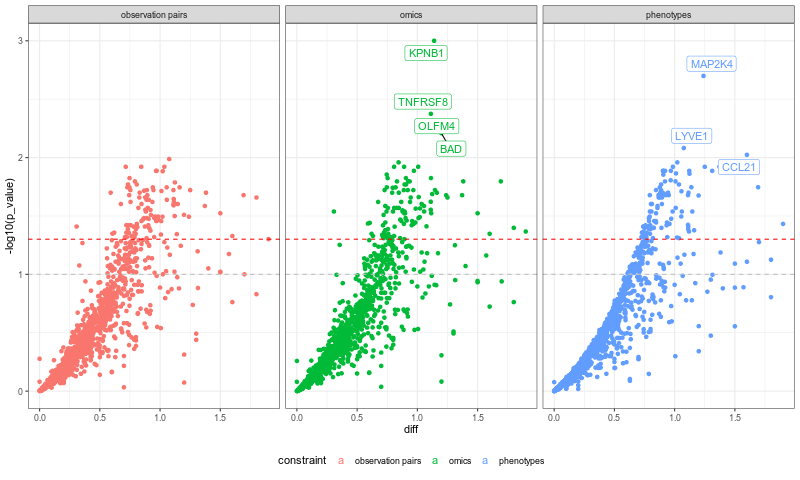

In [97]:
%%R -i p_values_molten -w 800

df = p_values_molten[
    p_values_molten$p_value < 0.01
    & p_values_molten$diff > 1,
    #& p_values_molten$constraint == 'observation pairs',
]

import::here(annotate_significance_thresholds, .from='plots/volcano.R')
(
    ggplot(p_values_molten, aes(x=diff, y=-log10(p_value), color=constraint))
    + facet_wrap('constraint')
    + geom_point() + nice_theme
    + annotate_significance_thresholds(0.05, 0.1, function(x){-log10(x)})
    + ggrepel::geom_label_repel(data=df, aes(label=gene))
)

Generally, the top genes are shared across the rejected hypotheses (NB: no FDR here yet!) 

And the rejections numbers are comparable; as one would expect the complete randomization (omics) provides slightly fewer rejections:

In [98]:
rejections = pd.concat(
    Series({
        p: sum(p_values[p] < alpha)
        for p in p_values.loc[:,p_values.columns.str.startswith('p.')]
    }).rename(lambda x: x.replace('p.', '# significant ')).to_frame(alpha).T
    for alpha in np.linspace(0.00, 0.1, 100)
).rename_axis('threshold').reset_index().melt('threshold')
rejections.head(3)

,threshold,variable,value
0,0.00000,# significant phenotypes,0
1,0.00101,# significant phenotypes,0
2,0.00202,# significant phenotypes,1


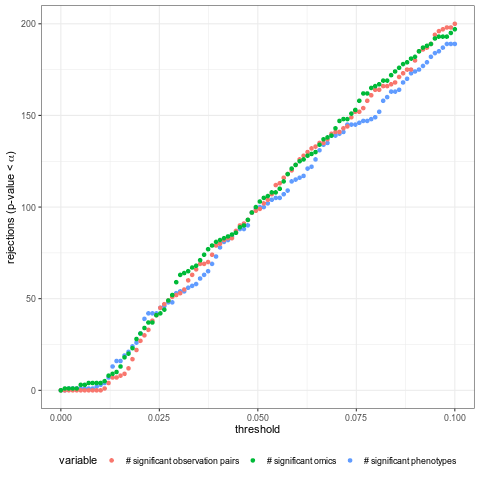

In [99]:
%%R -i rejections
ggplot(rejections, aes(x=threshold, y=value, color=variable)) + geom_point() + nice_theme + ylab(latex2exp::TeX('rejections (p-value < $\\alpha$)'))

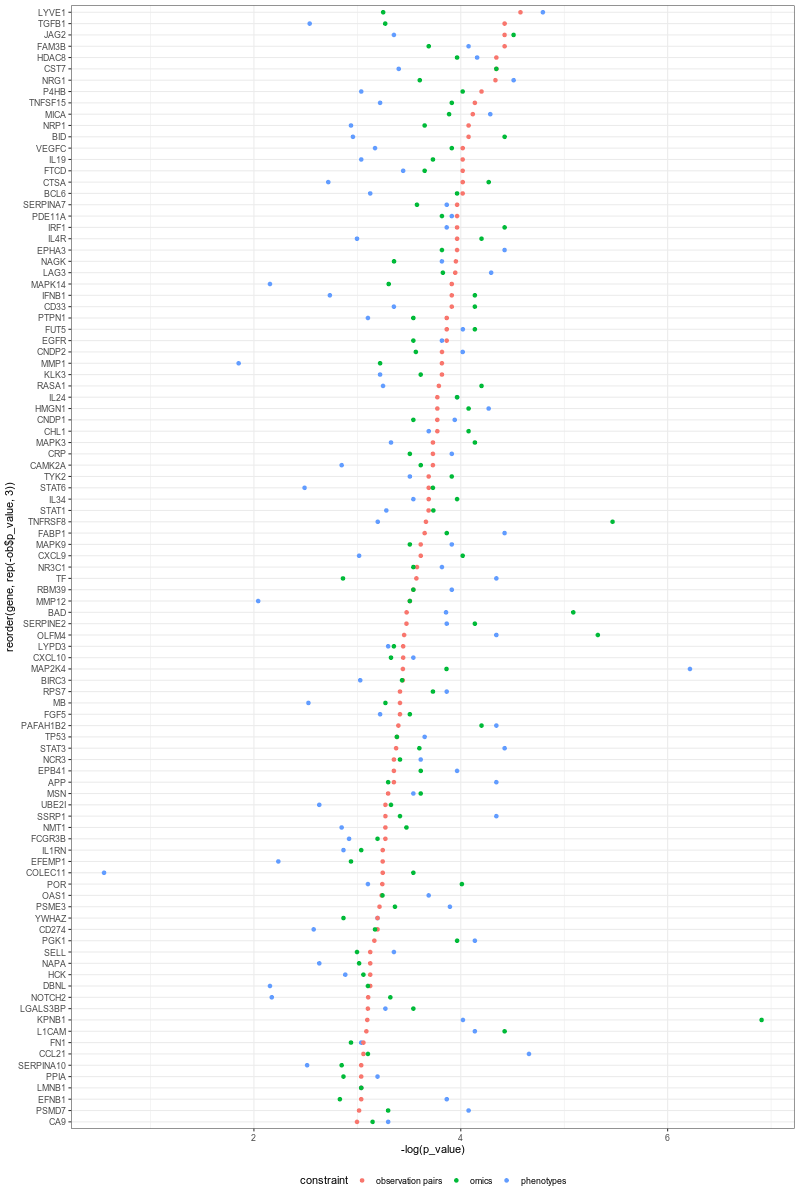

In [100]:
%%R -i p_values_molten -w 800 -h 1200
ob = p_values_molten[p_values_molten$p_value < 0.05 & p_values_molten$constraint=='observation pairs',]
genes = ob$gene
df = p_values_molten[p_values_molten$gene %in% genes,]
ggplot(df, aes(x=-log(p_value), y=reorder(gene, rep(-ob$p_value, 3)), color=constraint)) + geom_point() + nice_theme

Both NOTCH1 and NOTCH2 are high on the list...

#### 9.3 Adding independent hypothesis filtering

Two additional hypotheses were considered for independent filtering:
- geometric mean of abundances:
 $$a_g = \sqrt{
     \sqrt{
         |\text{RNA}_{\text{TB}}|_0
         \cdot
         |\text{Protein}_{\text{TB}}|_0
     }
     \cdot
     \sqrt{
         |\text{RNA}_{\text{CM}}|_0
         \cdot
         |\text{Protein}_{\text{CM}}|_0
     }
 }
 $$
 
 where $|\cdot|_0$ indicates arithmetic mean of normalized and log2-transformed RNA and Protein abundances (thus potentially a negative value for very low values) if positive or zero otherwise.
- geometric mean of number of patients with detectable levels of expression:
  $$n_g = \sqrt{
      \sqrt{
         \sum [\text{RNA}_{\text{TB}} > 0]
         \cdot
         \sum [\text{Protein}_{\text{TB}} > 0]
     }
     \sqrt{
         \sum [\text{RNA}_{\text{CM}} > 0]
         \cdot
         \sum [\text{Protein}_{\text{CM}} > 0]
     }
  }
  $$

 where $[\ \cdot\ ]$ denotes Iverson bracket (1 if the expression is true, 0 otherwise).
  
TODO: maybe rewrite the equation to use $\bar{\cdot}$ for arithmetic mean (to make it more intuitive) and fractional exponents (to reduce number of confusing horizontal lines)?

While neither of these is fully independent because for unexpressed transcripts/undetectable proteins the main null hypothesis cannot be rejected (trivially), for reasonably abundant transcript-protein pairs the independence assumption is reasonable.

In [101]:
%%R
plot_effect_on_p = function(data, x, n=10) {
    top_candidates = head(
        order(
            p_values_molten$p_value,
            p_values_molten$gene
        ),
        n=n
    )
    (
        ggplot(data, aes_string(x=x, y='-log10(p_value)', color='constraint'))
        + nice_theme
        + geom_point(alpha=0.5) + geom_smooth()
        + ggrepel::geom_label_repel(data=p_values_molten[top_candidates,], aes(label=gene))
    )
}

The $a_g$ is less correlated with the measured absolute correlation difference (diff) the p-values for nay of the hypotheses, than $n_g$: 

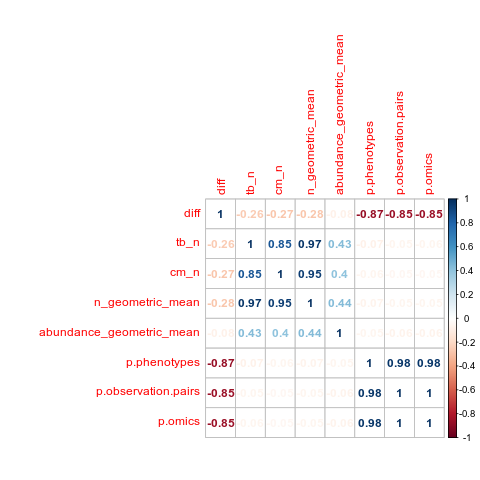

In [102]:
%%R -i p_values
corrplot::corrplot(cor(subset(p_values, select=-c(gene))), method="number")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


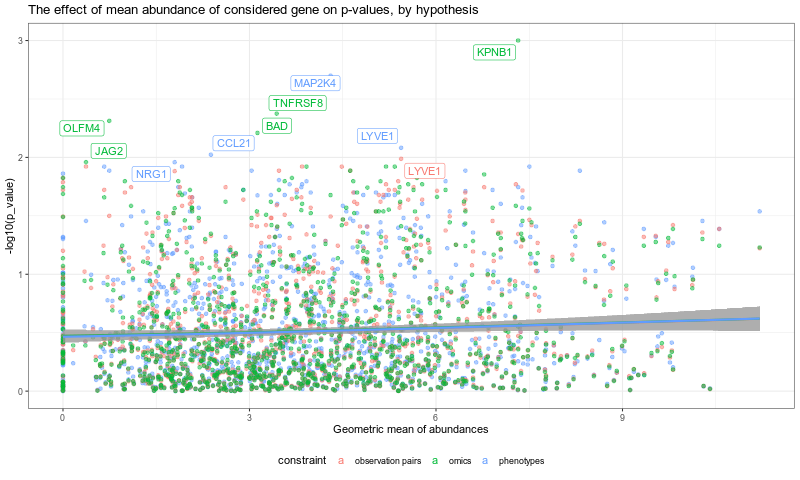

In [103]:
%%R -i p_values_molten -w 800
(
    plot_effect_on_p(p_values_molten, 'abundance_geometric_mean')
    + ggtitle('The effect of mean abundance of considered gene on p-values, by hypothesis')
    + xlab('Geometric mean of abundances')
)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


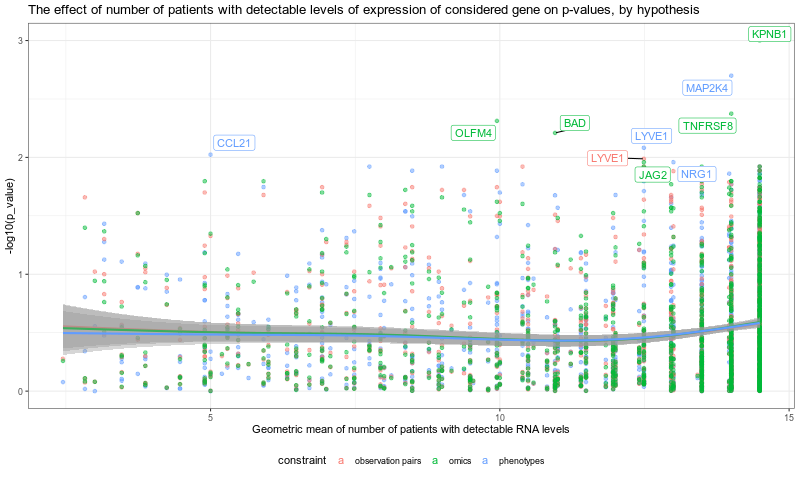

In [104]:
%%R -i p_values_molten -w 800
(
    plot_effect_on_p(p_values_molten, 'n_geometric_mean')
    + ggtitle('The effect of number of patients with detectable levels of expression of considered gene on p-values, by hypothesis')
    + xlab('Geometric mean of number of patients with detectable RNA levels')
)

$a_g$ also provides more information content than $n_g$, and thus was chosen to be used as the independent hypothesis for filtering step.

In [105]:
result = result.rename(columns=lambda x: x.replace(' ', '.'))

In [106]:
%%R
import::here(filter_by_mean_expression, .from='helpers/independent_hypothesis.R')

filter_by_mean_abundance = function(df, constraint, plot=F) {
    filter_by_mean_expression(
        df, expression_col='abundance_geometric_mean', pvalue_col=paste0('p_value.', constraint),
        fdr_threshold=0.05, use_deseq2_method=F, show_plot=plot
    )
}

In [107]:
filter_by_mean_abundance = partial(r_function, 'filter_by_mean_abundance')

In [108]:
result_without_fdr = result.copy()

In [109]:
for constraint in ['omics', 'phenotypes', 'observation.pairs']:
    result[f'FDR.filter.{constraint}'] = filter_by_mean_abundance(result, constraint)

In [110]:
summary_columns = [
    # correlations
    'tb_correlation', 'cm_correlation', 'diff',
    # mean abundance
    #'tb_abundance', 'cm_abundance',
    'abundance_geometric_mean',
    # number of patients with detectable levels
    'tb_n', 'cm_n', 'n_geometric_mean',
]

In [111]:
result = result.sort_values([
    'FDR.filter.observation.pairs', 'FDR.observation.pairs', 'p_value.observation.pairs'
])

In [112]:
result.to_csv(differential_correlations_path)

#### 9.4 Analysis of the results

Without filtering, there are no significant genes after multiple hypothesis testing correction (BH):

In [113]:
fdr_columns_no_filter = ['FDR.observation.pairs', 'FDR.omics', 'FDR.phenotypes']
summary_no_filter = result[summary_columns + fdr_columns_no_filter]
result[fdr_columns_no_filter].min()

FDR.observation.pairs    0.587032
FDR.omics                0.578335
FDR.phenotypes           0.603080
dtype: float64

In [114]:
summary_no_filter.sort_values('FDR.observation.pairs').head(10)

,tb_correlation,cm_correlation,diff,abundance_geometric_mean,tb_n,cm_n,n_geometric_mean,FDR.observation.pairs,FDR.omics,FDR.phenotypes
gene,,,,,,,,,,
LYVE1,0.713287,-0.362637,1.075924,5.438554,12,13,12.489996,0.587032,0.578335,0.603080
FAM3B,0.700000,-0.335664,1.035664,3.846088,9,12,10.392305,0.587032,0.578335,0.603080
TGFB1,0.664286,-0.050549,0.714835,4.485100,15,14,14.491377,0.587032,0.578335,0.627072
CST7,0.542857,-0.428571,0.971429,4.620205,15,14,14.491377,0.587032,0.578335,0.603080
HDAC8,0.353571,-0.613187,0.966758,3.474086,15,14,14.491377,0.587032,0.578335,0.603080
NRG1,0.467033,-0.554945,1.021978,1.796218,13,13,13.000000,0.587032,0.578335,0.603080
TNFSF15,0.472527,-0.318681,0.791209,5.392616,14,13,13.490738,0.587032,0.578335,0.603080
BID,0.806593,0.000000,0.806593,5.196181,14,13,13.490738,0.587032,0.578335,0.603080
NRP1,-0.160440,0.573626,0.734066,7.284380,14,14,14.000000,0.587032,0.578335,0.603080


With filtering, two genes can be claimed significant for hypothesis of interest (b): STAT3 and KPNB1.

In [115]:
fdr_columns_filter = ['FDR.filter.observation.pairs', 'FDR.filter.omics', 'FDR.filter.phenotypes']
summary_filter = result[summary_columns + fdr_columns_filter]
summary_filter.sort_values('FDR.filter.observation.pairs').head(10)

,tb_correlation,cm_correlation,diff,abundance_geometric_mean,tb_n,cm_n,n_geometric_mean,FDR.filter.observation.pairs,FDR.filter.omics,FDR.filter.phenotypes
gene,,,,,,,,,,
LYVE1,0.713287,-0.362637,1.075924,5.438554,12,13,12.489996,0.573564,0.569431,NaN
FAM3B,0.700000,-0.335664,1.035664,3.846088,9,12,10.392305,0.573564,0.569431,NaN
TGFB1,0.664286,-0.050549,0.714835,4.485100,15,14,14.491377,0.573564,0.569431,NaN
CST7,0.542857,-0.428571,0.971429,4.620205,15,14,14.491377,0.573564,0.569431,NaN
HDAC8,0.353571,-0.613187,0.966758,3.474086,15,14,14.491377,0.573564,0.569431,NaN
NRG1,0.467033,-0.554945,1.021978,1.796218,13,13,13.000000,0.573564,0.569431,NaN
TNFSF15,0.472527,-0.318681,0.791209,5.392616,14,13,13.490738,0.573564,0.569431,NaN
BID,0.806593,0.000000,0.806593,5.196181,14,13,13.490738,0.573564,0.569431,NaN
NRP1,-0.160440,0.573626,0.734066,7.284380,14,14,14.000000,0.573564,0.569431,NaN


For remaining hypotheses, the filtering step is over-aggressive, reducing to the test of the most abundant gene (B2M):

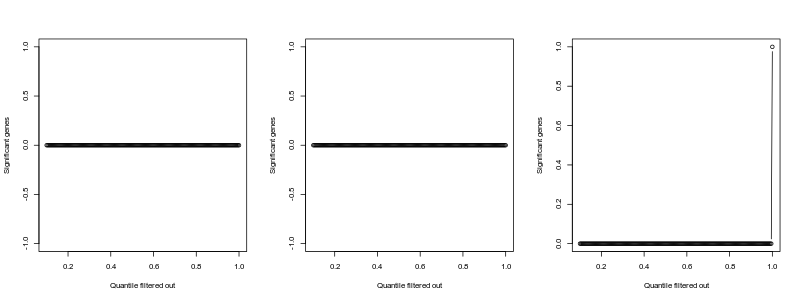

In [116]:
%%R -i result_without_fdr -w 800 -h 300
par(mfrow=c(1, 3))
filter_by_mean_abundance(result_without_fdr, 'observation.pairs', plot=T)
filter_by_mean_abundance(result_without_fdr, 'omics', plot=T)
filter_by_mean_abundance(result_without_fdr, 'phenotypes', plot=T)

In [117]:
summary_filter.sort_values('FDR.filter.omics').head(3)

,tb_correlation,cm_correlation,diff,abundance_geometric_mean,tb_n,cm_n,n_geometric_mean,FDR.filter.observation.pairs,FDR.filter.omics,FDR.filter.phenotypes
gene,,,,,,,,,,
LYVE1,0.713287,-0.362637,1.075924,5.438554,12,13,12.489996,0.573564,0.569431,NaN
FAM3B,0.700000,-0.335664,1.035664,3.846088,9,12,10.392305,0.573564,0.569431,NaN
TGFB1,0.664286,-0.050549,0.714835,4.485100,15,14,14.491377,0.573564,0.569431,NaN


#### 9.5 Graphical representation

I present three different summaries of this exploratory analysis:
- I) **permutation-test**: using full dataset and permutation test to determine candidates with statistically significant effect
- II) **permutation-test-mean-filtered**: same as above, but using independent filtering on mean abundance (geometric mean of means), which highlights the transcript-protein pairs with inverse correlations that are highly abundant:
  - the correlations for proteins at low abundance may be effects of technical variation which accounts for more and more of the apparent abundance when approaching the limits of the measurements resolution
  - pairs with high abundance are of greater interest to this study, which aimed at highlighting potential biomarkers; (obviously, the inversely correlated pairs are a small subset of potential biomarkers, but those may have a very interesting biological explanation)
- III) **weighted-by-support**: without using the permutation test, but weighting by the number of patients with data available for the statistic. This summary is presented for historic reasons as it was the first, preliminary result of this analysis.

In [118]:
from helpers.correlations.wrangling import prepare_opposite_correlations

get_opposite_correlations = partial(
    prepare_opposite_correlations,
    rna_shared=rna_shared, protein_shared=protein_shared,
    protein_hc=protein_hc, clinical=clinical
)

##### **I) permutation-test**

In [119]:
df = get_opposite_correlations(
    result.sort_values(['FDR.observation.pairs', 'p_value.observation.pairs']),
    additional_columns=['p_value.observation.pairs', 'FDR.observation.pairs']
)

`geom_smooth()` using formula 'y ~ x'


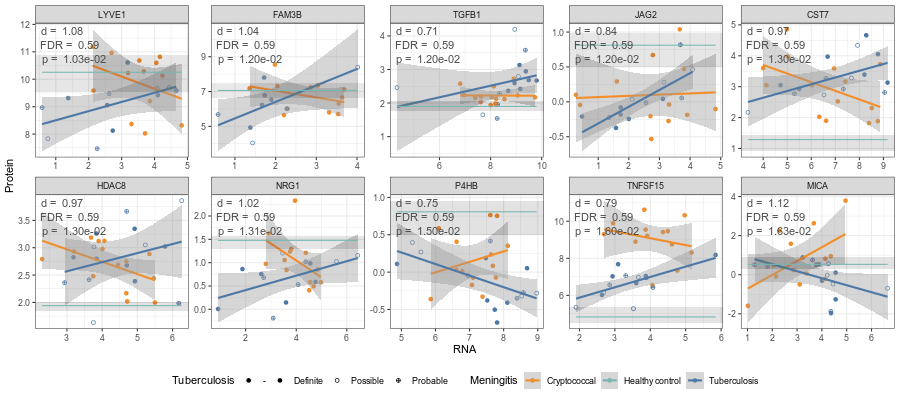

In [120]:
%%R -i df -w 900 -h 400
import::here(plot_opposite_correlations, .from='plots/correlations.R')

plot_opposite_correlations(df, fdr_column='FDR.observation.pairs', p_column='p_value.observation.pairs')

##### **II) permutation-test-mean-filtered**

In [121]:
df = get_opposite_correlations(
    result.sort_values(['FDR.filter.observation.pairs', 'p_value.observation.pairs']),
    additional_columns=['p_value.observation.pairs', 'FDR.filter.observation.pairs']
)

`geom_smooth()` using formula 'y ~ x'


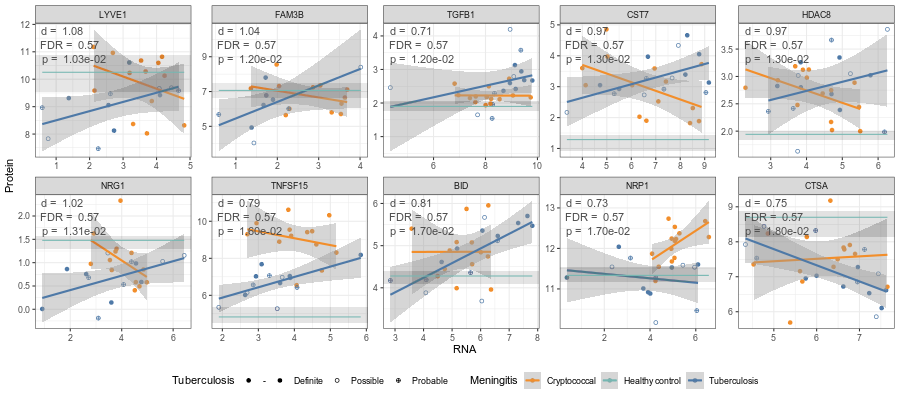

In [122]:
%%R -i df -w 900 -h 400
plot_opposite_correlations(df, fdr_column='FDR.filter.observation.pairs', p_column='p_value.observation.pairs')

##### **III) weighted-by-support**

(top results obtained before the permutation test)

In [123]:
cm_tm['diff_weighted'] = cm_tm['diff'] * result['n_geometric_mean']
df = get_opposite_correlations(
    cm_tm.sort_values('diff_weighted', ascending=False)
)

`geom_smooth()` using formula 'y ~ x'


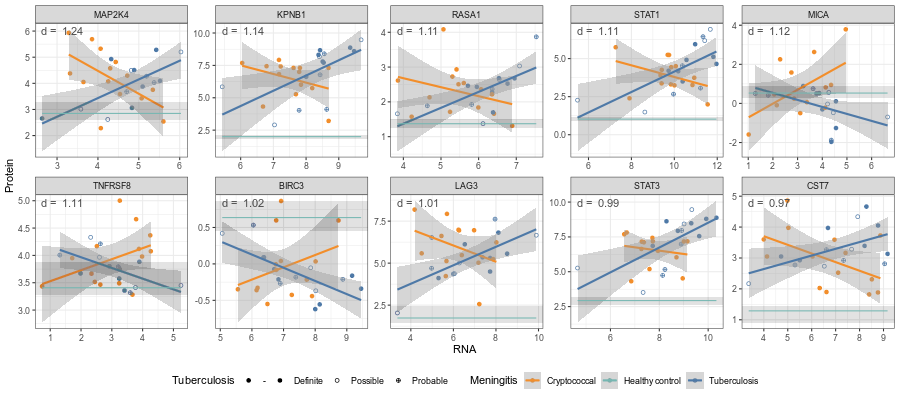

In [124]:
%%R -i df -w 900 -h 400
plot_opposite_correlations(df)

Top 5 (extracts from NCBI RefSeq gene reports):
- MAP2K4 (a.k.a MKK4; SEK1): Toll Like Receptor cascades, Signaling: MAPK, IL-1, IL-6, Wnt, TNF, TGF-β, FCϵ, ErbB
- KPNB1: HIV-1 replication, apoptosis, Interferon Signaling
- RASA1: stimulates the GTPase activity of RAS p21, Signaling: Aurora A, Aurora B, BCR, FCϵ, EGF/EGFR, EPO, EPHB, Insulin IL-2, IL-3,5, MAPK, NGF, VEGF, RAS and many more; T-Cell Receptor and Co-stimulatory Signaling
- STAT1: "can be activated by various ligands including interferon-alpha, interferon-gamma, EGF, PDGF and IL6 [...] mediates the expression of a variety of genes, which is thought to be important for cell viability in response to different cell stimuli and pathogens";
 - "HIV-1 infection upregulates basal mRNA levels of JUN, IL6, STAT1, CEBPA, RELA, and CEBPG in monocyte derived macrophages"
 - "HIV/**tuberculosis** coinfection upregulates STAT1 expression in pleural fluid mononuclear cells (PFMC) isolated from antiretroviral-naive coinfected patients (relative to patients infected with tuberculosis only)"
- TNFRSF8: TNF-receptor; expressed by activated T and B cells; interactions with HIV-1

The top 6 - STAT3 has a similar behaviour to STAT1 (and both are higher in TB and crypto than in HC!)

After comparing to the healthy controls we could say that KPNB1, STAT1, STAT3, BIRC3 and LAG3 may be worth investigating.

As I have held out some data (samples which are not shared are not included in is shared_protein not in shared_rna), we can now try independently validate if the abundance levels differ between crypto and TB:

TODO - but is this really useful?